# Evolent Health: Technical Exercise for Data Science Candidate

### **Imports**

In [1]:
import re
import warnings
from os import getcwd
from os.path import join, isfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from transformers import pipeline

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

### **Reading data**

In [3]:
# Defining paths
DATA_DIR = join(getcwd(), "data")
data_file_path = join(DATA_DIR, "BeerDataScienceProject.csv")

In [4]:
df = pd.read_csv(data_file_path, encoding="iso-8859-1")

In [5]:
# Basic info and preview
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508590 non-null  float64
 1   beer_beerId         528870 non-null  int64  
 2   beer_brewerId       528870 non-null  int64  
 3   beer_name           528870 non-null  object 
 4   beer_style          528870 non-null  object 
 5   review_appearance   528870 non-null  float64
 6   review_palette      528870 non-null  float64
 7   review_overall      528870 non-null  float64
 8   review_taste        528870 non-null  float64
 9   review_profileName  528755 non-null  object 
 10  review_aroma        528870 non-null  float64
 11  review_text         528751 non-null  object 
 12  review_time         528870 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 52.5+ MB


,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
277607,5.5,67119,22200,Egg Nog,Cream Ale,4.0,3.5,4.5,4.0,jlindros,4.0,Had on tap at EBF. Big creamy head with some s...,1299995448
500780,6.0,73341,132,Chatoe First Growth Good Chit Pilsner,Czech Pilsener,5.0,4.5,5.0,4.0,WVbeergeek,4.5,Pours with a slight chill haze with a bright l...,1324352489
124373,11.0,56232,273,Sweetwater Dank Tank BSP Quad Ale,Quadrupel (Quad),4.0,4.0,4.5,4.0,gford217,4.5,Pours dark mahogany in the glass but shows thr...,1271480365
497171,9.5,358,132,XS Imperial India Pale Ale,American Double / Imperial IPA,4.0,4.5,4.5,4.0,CrashWorship,5.0,Ryan and John's Fat Head's Session II: Appeara...,1069361248
100553,6.5,30358,2299,Ichtegem's Grand Cru,Flanders Red Ale,4.0,3.0,3.5,3.0,DaveHS,3.5,A-Pours deep brown with ruby highlights and a ...,1296866367


### **Missing Values**

In [6]:
df_na = df.dropna()
print(f"Percentage of values missing: {(1 - (df_na.shape[0] / df.shape[0])) * 100:.2f}%")

Percentage of values missing: 3.88%


### **Duplicate Values**

In [7]:
print(f"Total number of duplicate values: {df_na.shape[0] - df_na.drop_duplicates().shape[0]}")

Total number of duplicate values: 0


## **Question 1**: Top 3 breweries with strongest beer

Since the strenght of any alcoholic beverage is defined by the alcohol content. Therefore, the average ABV is a good indicator of the strength of the beer

In [8]:
average_alcohol_content = df_na.groupby(['beer_brewerId']).mean()['beer_ABV']
average_alcohol_content.head()

beer_brewerId
1     4.438717
3     5.537475
5     4.790072
10    4.973214
14    6.939831
Name: beer_ABV, dtype: float64

In [9]:
average_alcohol_content = average_alcohol_content.sort_values(ascending=False).head(3)
average_alcohol_content

beer_brewerId
6513     19.228824
736      13.750000
24215    12.466667
Name: beer_ABV, dtype: float64

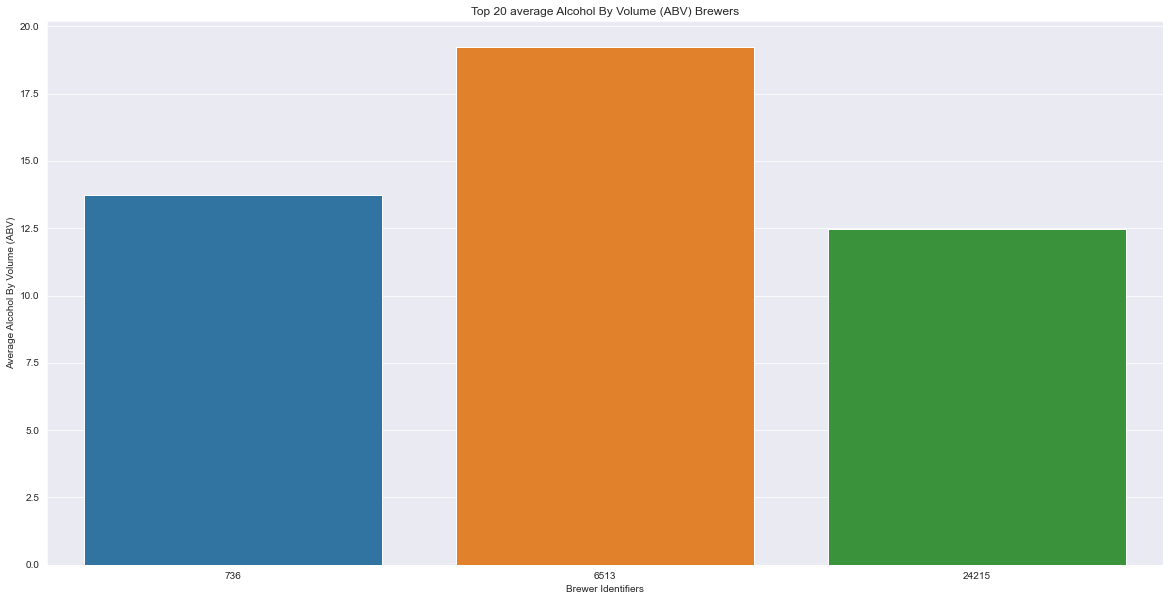

In [10]:
plt.figure(figsize=(20, 10))
plt.title("Top 20 average Alcohol By Volume (ABV) Brewers")
sns.barplot(average_alcohol_content.index, average_alcohol_content)
plt.ylabel("Average Alcohol By Volume (ABV)")
plt.xlabel("Brewer Identifiers")
plt.show()

In [11]:
del average_alcohol_content

## **Question 2**: Which year did beers enjoy the highest ratings?

Here, the average rating of all the beers in each year is a calculated. This is due the fact that every year has beer that is rated $5$ which is the highest rating. This will not provide us any useful insight, whilst the average rating of beer for year will allow us liking towards the beer 

In [12]:
df_na['year'] = pd.to_datetime(df_na['review_time'], unit='s').apply(lambda x: x.year)

In [13]:
average_rating = df_na.groupby('year').mean()['review_overall']
average_rating

year
1998    4.045455
1999    4.000000
2000    4.233333
2001    3.961896
2002    3.817551
2003    3.772793
2004    3.806632
2005    3.844657
2006    3.809104
2007    3.819879
2008    3.840345
2009    3.868749
2010    3.869430
2011    3.833394
2012    3.839082
Name: review_overall, dtype: float64

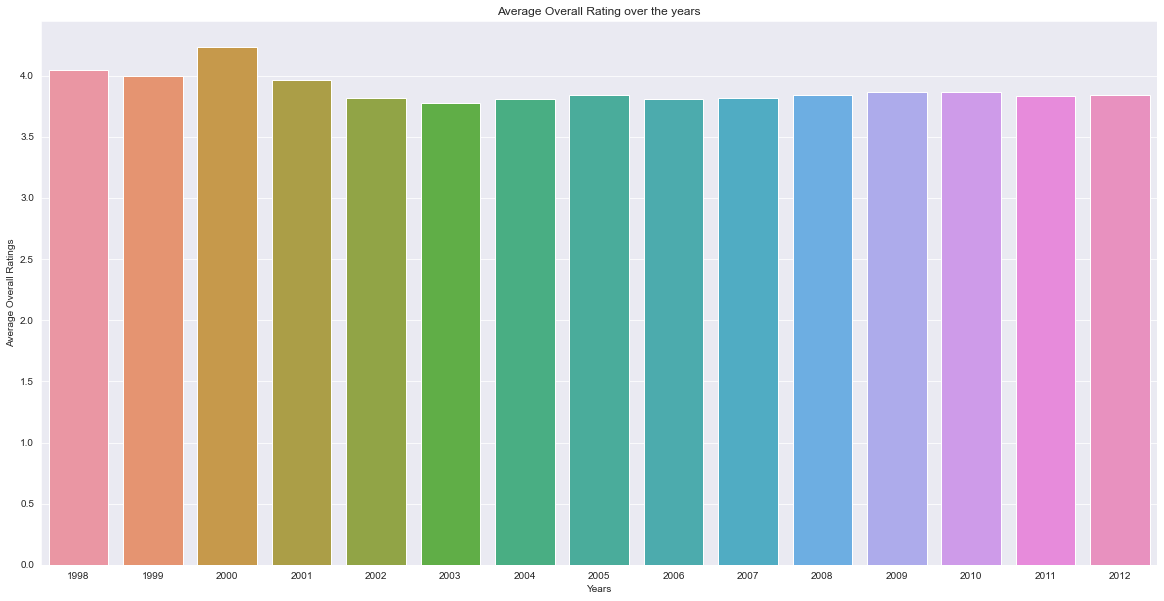

In [14]:
plt.figure(figsize=(20, 10))
plt.title("Average Overall Rating over the years")
sns.barplot(average_rating.index, average_rating)
plt.xlabel("Years")
plt.ylabel("Average Overall Ratings")
plt.show()

In [15]:
average_rating.sort_values(ascending=False).head()

year
2000    4.233333
1998    4.045455
1999    4.000000
2001    3.961896
2010    3.869430
Name: review_overall, dtype: float64

In [16]:
del average_rating

## **Question 3**: Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

Since implicitly all the factors viz. taste, aroma, appreance, and palette, interact with each other and form the overall rating, there will be a correlation among the overall rating and rating in these factors. The factor whose correlation is the highest, will be the most important factor.

In [17]:
rating_df = df_na[['review_appearance', 'review_aroma', 'review_palette',
                   'review_taste', 'review_overall']]
rating_df.sample(5)

,review_appearance,review_aroma,review_palette,review_taste,review_overall
131902,4.5,4.0,3.5,4.5,4.5
270809,4.5,4.5,4.0,3.5,4.0
267864,3.5,4.0,4.0,3.5,4.0
270611,3.5,3.0,2.5,3.0,3.0
54787,3.0,2.5,1.0,2.5,2.5


In [18]:
rating_correlation = rating_df.corr()
rating_correlation

,review_appearance,review_aroma,review_palette,review_taste,review_overall
review_appearance,1.000000,0.531204,0.544724,0.551979,0.483091
review_aroma,0.531204,1.000000,0.703428,0.722737,0.780310
review_palette,0.544724,0.703428,1.000000,0.600842,0.598048
review_taste,0.551979,0.722737,0.600842,1.000000,0.689276
review_overall,0.483091,0.780310,0.598048,0.689276,1.000000


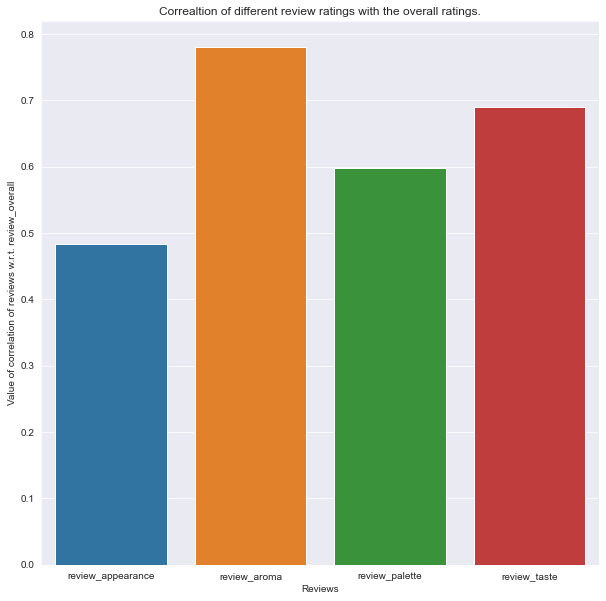

In [19]:
plt.figure(figsize=(10, 10))
plt.title("Correaltion of different review ratings with the overall ratings.")
sns.barplot(rating_correlation.index[:-1], rating_correlation.review_overall[:-1])
plt.xlabel("Reviews")
plt.ylabel("Value of correlation of reviews w.r.t. review_overall")
plt.show()

In [20]:
del rating_df, rating_correlation

## **Question 4**: If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

This is question in my understanding is a little subjective, because it tallks about the recommendation and to my friends. I know for a fact that, if a beer does not a ample amout reviews, my friends will not touch the beer. Further more as we saw in the prevoius answer appearance, aroma, palette and tase form an overall rating. Alcohol content is also of an import. Therefore combining these factors, the suggestions are created. 

In [21]:
ratings_alcohol_columns = ['beer_ABV', 'review_appearance', 'review_aroma',
                           'review_palette', 'review_taste', 'review_overall']
rating_alcohol_df = df_na.groupby('beer_name').mean()[ratings_alcohol_columns]
rating_alcohol_df['num_reviews'] = df_na.groupby('beer_name').count()['review_text']
rating_alcohol_df[rating_alcohol_df.num_reviews >= 100].sort_values(by=['review_overall', 'beer_ABV'], ascending=False).iloc[:3]

,beer_ABV,review_appearance,review_aroma,review_palette,review_taste,review_overall,num_reviews
beer_name,,,,,,,
Citra DIPA,8.0,4.369048,4.573413,4.690476,4.373016,4.630952,252
Cantillon Blåbær Lambik,5.0,4.644231,4.628205,4.528846,4.493590,4.628205,156
Heady Topper,8.0,4.163113,4.608742,4.660981,4.405117,4.625800,469


In [22]:
del rating_alcohol_df, ratings_alcohol_columns

## **Question 5**: Which Beer style seems to be the favorite based on reviews written by users?

I was unable to find a solution of this question.

## **Question 6**: How does written review compare to overall review score for the beer styles?

My proposed way is to find a numnerical value for each review we have. I have chosen to use sentiment analysis. This will not only provid us sentiment but also value assciated with it. This can be then translated to a value between $[0, 5]$, which is also the range of our ratings. Once these values are obtained, we can do the necessary comparison. I here had 2 limitations. Due the hardware limitations, I had to use a sentiment analyzer which gave answers in binary, and had to sample the rerviews instead of using all of them. 

In [ ]:
sentiment_classifier = pipeline('sentiment-analysis', model="siebert/sentiment-roberta-large-english")

In [ ]:
def get_sentiment_score(review: str):
    """
    Takes as input a review and returns a float value representing its sentiment.
    """
    try:
        sentiment_dict = sentiment_classifier(review)[0]
        if sentiment_dict['label'] == "NEGATIVE":
            return -1 * sentiment_dict['score']
        return sentiment_dict['score']
    except Exception:
        return np.nan

In [ ]:
sentiment_file = join(DATA_DIR, "sentiment_sample_data.csv")

In [ ]:
if isfile(sentiment_file):
    df_na_sample = pd.read_csv(sentiment_file, index_col='original_index')
else:
    df_na_sample = df_na.sample(10)
    df_na_sample['sentiment_score'] = df_na_sample.review_text.apply(get_sentiment_score)
    df_na_sample.to_csv(sentiment_file, index=True, index_label="original_index")

df_na_sample = df_na_sample.dropna()
df_na_sample.head()

In [ ]:
df_na_sample.sentiment_score += 1
df_na_sample.sentiment_score *= (5 / 2)
df_na_sample.sentiment_score.head()

In [ ]:
df_na_sample.sentiment_score.hist(bins=20)

In [ ]:
sample_corr = df_na_sample.corr()
sample_corr.loc[['review_overall', 'sentiment_score'], ['review_overall', 'sentiment_score']]

In [ ]:
mean_squared_error(df_na_sample.review_overall, df_na_sample.sentiment_score)

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Predicted sentiment vs Overall rating")
sns.scatterplot(df_na_sample.index, df_na_sample.review_overall, label="Overall rating")
sns.scatterplot(df_na_sample.index, df_na_sample.sentiment_score, label="Predicted rating from review text")
plt.xlabel("Samples")
plt.ylabel("Rating / Sentiment Score")
plt.show()

In [ ]:
del df_na_sample, sample_corr

## **Question 7**: How do find similar beer drinkers by using written reviews only?

The process, I will follow is as follows:
1. Preprocessing the text.
    1. Cleaning the data:
        - Converting to lower cases.
        - Expanding the contracted terms. 
        - Experiment with removing stopwords.
        > Note: Since we are tackling a problem of pattern recognition, removing the stopwords might change the pattern and reduce the performance of our model.
    2. Vectorisation
        - Finding 2-grams and 3-grams.
        - Creating TF vectors. 
        > Note: we can use TF-IDF vectors too. 
2. Training a unsuprevised model.
    1. I would like to train a hierarchical agglomerative clustering model. This type of model will allow us to select the number of cluster on the fly and therefore have flexibility.
    > Note: This is based on the assumption that the review about a particular beer will be writing same kind reviews. 
    2. I will also try topic modeling. This will allow us to find the topics the beer reviewrs are generally writing about.
    > Note: This methodology also has an assumption which is that the similar beer drinker will be reviewing about same topics in the reviews.